In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing
from keras.datasets import imdb

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


<br>
<br>

# 데이터 로드

In [2]:
# 단어의 최대 개수
max_words = 10000

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 500

# 임베딩 벡터 차원
embedding_dim = 100

# IMDb 리뷰 데이터를 최대 단어 10000개로 제한하여 가져옴
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_words)

In [3]:
# 훈련셋 크기
train_data.shape


(25000,)

In [4]:
# 훈련셋 라벨 크기
train_labels.shape


(25000,)

In [5]:
# 테스트셋 크기
test_data.shape


(25000,)

In [6]:
# 테스트셋 라벨 크기
test_labels.shape


(25000,)

<br>
<br>

# 전처리

In [7]:
# 훈련셋에 패딩 추가
x_train = preprocessing.sequence.pad_sequences(train_data,
                                               maxlen=max_sequences,
                                               padding='post')

# 테스트셋에 패딩 추가
x_test = preprocessing.sequence.pad_sequences(test_data,
                                              maxlen=max_sequences,
                                              padding='post')

pad_sequences() 함수는 maxlen 만큼 0으로 패딩을 추가합니다. 보통 텍스트를 처리할 때, 이렇게 입력을 동일한 길이로 맞추는 작업을 합니다. padding이 'post'면 데이터의 뒤에 패딩을 합니다. 디폴트는 'pre'로 앞에 패딩을 수행합니다.
<br>
<br>
<br>

In [8]:
# 첫 번째 훈련셋 출력
x_train[0]


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [9]:
# 레이블을 벡터로 변환
# 0, 1 정수를 그냥 실수로 변환하는 것
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [10]:
# 벡터로 변환한 훈련 데이터 라벨 출력
y_train


array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [11]:
# 훈련셋에서 검증셋 분리
x_val = x_train[:10000]
x_train_new = x_train[10000:]

y_val = y_train[:10000]
y_train_new = y_train[10000:]

<br>
<br>

# 모델 생성

In [12]:
def build_model():

    model = models.Sequential()
    model.add(layers.Embedding(max_words, embedding_dim, input_length=max_sequences))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(64, 8, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(64, 8, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    

    return model

Embedding()으로 임베딩을 먼저 한 후에 컨볼루션과 맥스 풀링을 반복해서 수행합니다. 이전 이미지 인식일 때는 Conv2D() 였지만, 여기서는 Conv1D()를 사용합니다. 첫 번째 파라미터는 필터의 개수로 동일합니다. 하지만 두 번째 파라미터의 경우 (3, 3)같은 이차원 필터가 아니라 8이란 일차원 상수입니다.

중요한 점은 Conv1D의 필터도 똑같이 2차원이라는 것입니다. 다만 필터의 가로 길이가 항상 임베딩 차원으로 고정됩니다. 임베딩인 (단어의 개수, 임베딩 차원)에서 8은 단어의 개수를 의미합니다. 8개의 단어의 범위만큼 문맥을 고려하여 특성 맵을 작성합니다. 그래서 실제로는 (8, 100)이 필터의 크기가 됩니다.

만약 (3, 3)처럼 단어 하나의 임베딩을 중간에 끊어버리면 단어의 의미가 사라져 버립니다. 이렇게 Conv1D()와 Conv2D()는 필터의 크기를 설정하는 방식이 다르다는 것을 기억하시기 바랍니다.

MaxPooling1D() 역시 필터의 크기가 일차원 상수입니다. Conv1D()를 거치면 특성 맵이 일차원이기 때문에 맥스 풀링의 필터도 일차원일 수밖에 없습니다. 5단위로 압축을 하면, 아래 모델의 구조처럼 493/5 -> 98로 변경됩니다. 

GlobalMaxPooling1D()은 필터의 크기가 필요없습니다. 필터의 크기는 입력의 전체 개수가 디폴트입니다. 그래서 출력이 딱 하나의 값으로만 나옵니다. 아래를 보면 (91, 64)에서 (64)로 바뀌었는데, 이는 91의 입력을 전체 맥스 풀링하여 1개로 출력되었기 때문입니다.
<br>
<br>
<br>

In [13]:
# 모델의 구조 출력
model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 493, 64)           51264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 91, 64)            32832     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
__________

<br>
<br>

# 훈련 및 평가

In [14]:
# 모델 생성
model = build_model()

# 훈련 시작
history = model.fit(x_train_new,
                    y_train_new,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 184s 12ms/step - loss: 0.6822 - acc: 0.5519 - val_loss: 0.6396 - val_acc: 0.5784
Epoch 2/10
15000/15000 [==============================] - 183s 12ms/step - loss: 0.4716 - acc: 0.7863 - val_loss: 0.4583 - val_acc: 0.7809
Epoch 3/10
15000/15000 [==============================] - 183s 12ms/step - loss: 0.3267 - acc: 0.8598 - val_loss: 0.3090 - val_acc: 0.8690
Epoch 4/10
15000/15000 [==============================] - 184s 12ms/step - loss: 0.2668 - acc: 0.8907 - val_loss: 0.2943 - val_acc: 0.8757
Epoch 5/10
15000/15000 [==============================] - 184s 12ms/step - loss: 0.2155 - acc: 0.9175 - val_loss: 0.4128 - val_acc: 0.8254
Epoch 6/10
15000/15000 [==============================] - 183s 12ms/step - loss: 0.1792 - acc: 0.9329 - val_loss: 0.3100 - val_acc: 0.8781
Epoch 7/10
15000/15000 [==============================] - 185s 12ms/step - loss: 0.1428 - acc: 0.9495 - val_loss: 0.

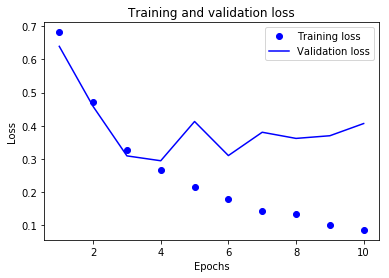

In [15]:
loss = history.history['loss']         # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')      # bo -> 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b -> 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


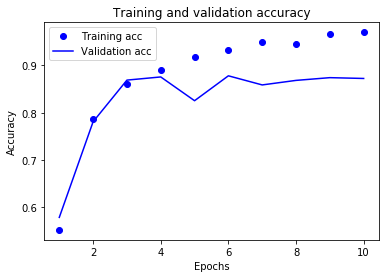

In [16]:
# 그래프 초기화
plt.clf()

acc = history.history['acc']           # 훈련 정확도
val_acc = history.history['val_acc']   # 검증 정확도

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


이전 Dense로만 구성된 모델의 검증 정확도는 86.7%가 최대였습니다. Conv1D를 적용한 모델에서는 87.8%로 조금 향상되었습니다.
<br>
<br>
<br>

In [17]:
# 모델 저장
model.save('./model/movie_review_conv1d_model.h5')

<br>
<br>

# 테스트셋 확인

In [18]:
# 저장된 모델 파일 로드
model = models.load_model('./model/movie_review_conv1d_model.h5')

In [19]:
# 테스트셋 평가
results = model.evaluate(x_test, y_test)
results


25000/25000 [==============================] - 80s 3ms/step


[0.4340641733789444, 0.85908]

테스트셋 정확도 역시 이전 85.0%에서 85.9%로 약간 증가했습니다.